In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import sys
from pathlib import Path
import pandas as pd
import os
from scipy.stats import pearsonr, spearmanr


module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from util import CHAPTERS_DATA_TSV, get_scenes_df

In [3]:
def get_shot_lenghts_in_chapter(
    df: pd.DataFrame, start: float | int | None, end: float | int | None
) -> int | None:
    """Returns list of shot lengths between start and end timestamp (in millisecs)."""
    mask = (df["start"] <= end) & (df["end"] >= start)
    rows = df.loc[mask].dropna()
    rows["shot_len_secs"] = rows.apply(
        lambda row: round((row["end"] - row["start"]) / 1000, 2), axis=1
    )

    return rows["shot_len_secs"].to_list()

In [4]:
# Load chapters
tsv_file = Path(CHAPTERS_DATA_TSV).resolve()
df = pd.read_csv(tsv_file, sep="\t")

# Only data with timestamps and shot counts
df = df[(df["start"].notna()) & (df["end"].notna())& (df["shot_count"].notna())]
len(df)

2369

In [5]:
DF_COMBAT = df[(df["is_combat_scene"].notna()) & (df["is_combat_scene"])]
DF_WAR_REPORT = df[(df["is_war_report"].notna()) & (df["is_war_report"])]
DF_SOLDIERS = df[(df["german_soldiers_depicted"].notna()) & (df["german_soldiers_depicted"])]

In [6]:
df_description = "flagged as combat scenes"
df = DF_COMBAT

print(f"Data size: {len(df)}")

# Number of cuts is number of shots minus 1
df["cuts_no"] = df["shot_count"].apply(lambda x: max(0, x - 1))

Data size: 751


In [7]:
df["cuts_no"].describe()

count    751.000000
mean      42.130493
std       32.737119
min        1.000000
25%       19.000000
50%       34.000000
75%       53.000000
max      200.000000
Name: cuts_no, dtype: float64

In [8]:
x = df['episode']
y = df['cuts_no']

pearson_r, pearson_p = pearsonr(x, y)
spearman_r, spearman_p = spearmanr(x, y)
mean = df["cuts_no"].mean()
median = df["cuts_no"].median()
std = df["cuts_no"].std()
print(f"Median: {median:.2f}")
print(f"Mean: {mean:.2f}")
print(f"Standard deviation: {std:.2f}")
print(f"Pearson:\tr = {pearson_r}\tp={pearson_p}")
print(f"Spearman:\tr = {spearman_r}\tp={spearman_p}")

Median: 34.00
Mean: 42.13
Standard deviation: 32.74
Pearson:	r = 0.17649809973171282	p=1.1329218211578944e-06
Spearman:	r = 0.21476384506584723	p=2.7616538595438257e-09


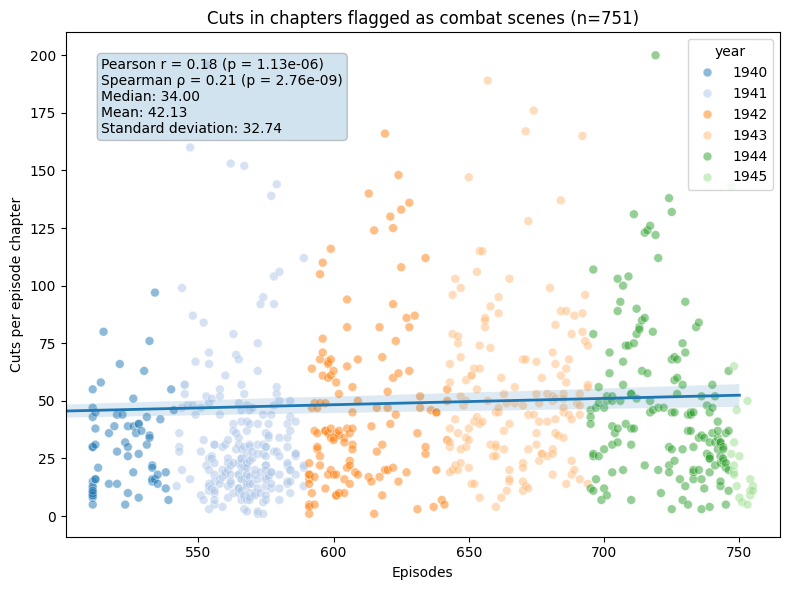

In [9]:
df_sorted = df.sort_values(["episode", "chapter"]).reset_index(drop=True)

text = (
    f"Pearson r = {pearson_r:.2f} (p = {pearson_p:.3g})\n"
    f"Spearman ρ = {spearman_r:.2f} (p = {spearman_p:.3g})\n"
    f"Median: {median:.2f}\n"
    f"Mean: {mean:.2f}\n"
    f"Standard deviation: {std:.2f}"
)

plt.figure(figsize=(8, 6))

ax = sns.scatterplot(  
    data=df_sorted,
    x="episode",
    y="cuts_no",
    hue="year",
    alpha=0.5,
    palette="tab20",
    legend="auto",
    s=40,
)

ax = sns.regplot(
    x=df_sorted.index,
    y=df_sorted["cuts_no"],
    scatter=False,
    line_kws={"linewidth": 2},
)

plt.text(
    0.05,
    0.95,
    text,
    transform=plt.gca().transAxes,
    verticalalignment="top",
    bbox=dict(boxstyle="round", alpha=0.2),
)

plt.xlim(min(df["episode"]) - 10, max(df["episode"]) + 10)
# plt.ylim(0, 120)
plt.xlabel("Episodes")
plt.ylabel("Cuts per episode chapter")
plt.title(f"Cuts in chapters {df_description} (n={len(df_sorted)})")
sns.move_legend(ax, "upper right",bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

In [10]:
df["shot_len"] = df.apply(lambda row: get_shot_lenghts_in_chapter(get_scenes_df(row["filestem"]), row["start"], row["end"]), axis=1)

In [11]:
# Create new dataframe where each shot has its own row
df_single_shot_lens = (
    df.explode("shot_len")
    # .rename(columns={"shot_len": "shot_len"})
    .reset_index(drop=True)
)
df_single_shot_lens["episode"] = df_single_shot_lens["episode"].astype(int)
df_single_shot_lens["year"] = df_single_shot_lens["year"].astype(int)
df_single_shot_lens["shot_len"] = df_single_shot_lens["shot_len"].astype(float)
df_single_shot_lens = df_single_shot_lens.dropna(subset=["episode", "shot_len"])
df_single_shot_lens

,title,chapter,start_mm:ss,end_mm:ss,is_war_report,is_combat_scene,german_soldiers_depicted,shot_count,content,audio_transcription,filestem,episode,year,start,end,start_frame,end_frame,cuts_no,shot_len
0,Die Deutsche Wochenschau Nr. 511 / 1940,1,00:46,02:13,True,True,True,16.0,"1. Luftkrieg über Le Havre, Frankreich, 1940 N...",Der Reich ist in voller Schärfe entbrannt. Wie...,511_1940,511,1940,46000.0,133000.0,1150.0,3325.0,15.0,2.48
1,Die Deutsche Wochenschau Nr. 511 / 1940,1,00:46,02:13,True,True,True,16.0,"1. Luftkrieg über Le Havre, Frankreich, 1940 N...",Der Reich ist in voller Schärfe entbrannt. Wie...,511_1940,511,1940,46000.0,133000.0,1150.0,3325.0,15.0,2.00
2,Die Deutsche Wochenschau Nr. 511 / 1940,1,00:46,02:13,True,True,True,16.0,"1. Luftkrieg über Le Havre, Frankreich, 1940 N...",Der Reich ist in voller Schärfe entbrannt. Wie...,511_1940,511,1940,46000.0,133000.0,1150.0,3325.0,15.0,2.12
3,Die Deutsche Wochenschau Nr. 511 / 1940,1,00:46,02:13,True,True,True,16.0,"1. Luftkrieg über Le Havre, Frankreich, 1940 N...",Der Reich ist in voller Schärfe entbrannt. Wie...,511_1940,511,1940,46000.0,133000.0,1150.0,3325.0,15.0,2.44
4,Die Deutsche Wochenschau Nr. 511 / 1940,1,00:46,02:13,True,True,True,16.0,"1. Luftkrieg über Le Havre, Frankreich, 1940 N...",Der Reich ist in voller Schärfe entbrannt. Wie...,511_1940,511,1940,46000.0,133000.0,1150.0,3325.0,15.0,1.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32386,Die Deutsche Wochenschau Nr. 755 / 1945,2,01:46,02:11,True,True,True,12.0,"2. Volkssturm, Deutsches Reich, 1945. Ein Sold...",Panzerfaustschießen in einer deutschen Stadt. ...,755_1945,755,1945,106000.0,131000.0,2544.0,3144.0,11.0,4.56
32387,Die Deutsche Wochenschau Nr. 755 / 1945,2,01:46,02:11,True,True,True,12.0,"2. Volkssturm, Deutsches Reich, 1945. Ein Sold...",Panzerfaustschießen in einer deutschen Stadt. ...,755_1945,755,1945,106000.0,131000.0,2544.0,3144.0,11.0,2.24
32388,Die Deutsche Wochenschau Nr. 755 / 1945,2,01:46,02:11,True,True,True,12.0,"2. Volkssturm, Deutsches Reich, 1945. Ein Sold...",Panzerfaustschießen in einer deutschen Stadt. ...,755_1945,755,1945,106000.0,131000.0,2544.0,3144.0,11.0,2.24
32389,Die Deutsche Wochenschau Nr. 755 / 1945,2,01:46,02:11,True,True,True,12.0,"2. Volkssturm, Deutsches Reich, 1945. Ein Sold...",Panzerfaustschießen in einer deutschen Stadt. ...,755_1945,755,1945,106000.0,131000.0,2544.0,3144.0,11.0,3.68


In [12]:
x = df_single_shot_lens['episode']
y = df_single_shot_lens['shot_len']

pearson_r, pearson_p = pearsonr(x, y)
spearman_r, spearman_p = spearmanr(x, y)
mean = df_single_shot_lens["shot_len"].mean()
median = df_single_shot_lens["shot_len"].median()
std = df_single_shot_lens["shot_len"].std()
print(f"Median: {median:.2f}")
print(f"Mean: {mean:.2f}")
print(f"Standard deviation: {std:.2f}")
print(f"Pearson:\tr = {pearson_r}\tp={pearson_p}")
print(f"Spearman:\tr = {spearman_r}\tp={spearman_p}")

Median: 2.88
Mean: 4.01
Standard deviation: 4.16
Pearson:	r = -0.1760949804228415	p=7.119465281772981e-224
Spearman:	r = -0.2339833532441901	p=0.0


In [13]:
episode_stats = df_single_shot_lens.groupby(['episode', 'year'])['shot_len'].agg(
    mean_shot_len='mean',
    median_shot_len='median',
    q25=lambda x: x.quantile(0.25),
    q75=lambda x: x.quantile(0.75)
).reset_index()

In [14]:
episode_stats.groupby('year')['episode'].min()

year
1940    511
1941    542
1942    591
1943    643
1944    695
1945    747
Name: episode, dtype: int64

/tmp/ipykernel_6573/2958937248.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(year_ticks.index.astype(int) - 1)


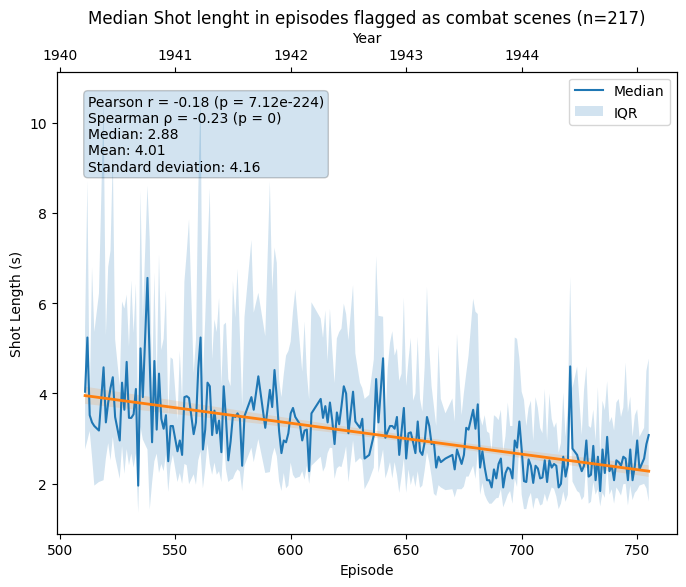

In [15]:
plt.figure(figsize=(8, 6))
text = (
    f"Pearson r = {pearson_r:.2f} (p = {pearson_p:.3g})\n"
    f"Spearman ρ = {spearman_r:.2f} (p = {spearman_p:.3g})\n"
    f"Median: {median:.2f}\n"
    f"Mean: {mean:.2f}\n"
    f"Standard deviation: {std:.2f}"
)
sns.lineplot(data=episode_stats, x="episode", y="median_shot_len", label="Median")
plt.fill_between(
    episode_stats["episode"], episode_stats["q25"], episode_stats["q75"], alpha=0.2, label="IQR"
)
ax = sns.regplot(
    x=episode_stats["episode"],
    y=episode_stats["median_shot_len"],
    scatter=False,
    line_kws={"linewidth": 2},
)
plt.text(
    0.05,
    0.95,
    text,
    transform=plt.gca().transAxes,
    verticalalignment="top",
    bbox=dict(boxstyle="round", alpha=0.2),
)

plt.xlabel("Episode")
plt.ylabel("Shot Length (s)")
plt.title(f"Median Shot lenght in episodes {df_description} (n={len(episode_stats)})")
ax.legend()

year_ticks = episode_stats.groupby("year")["episode"].min()
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticklabels(year_ticks.index.astype(int) - 1)
ax2.set_xlabel("Year")
plt.show()

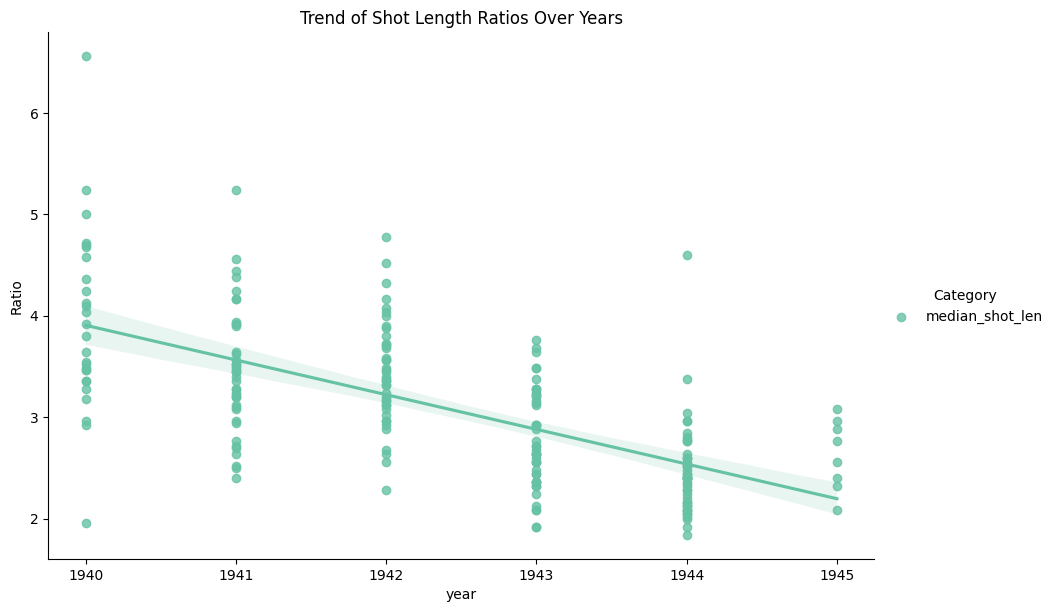

In [17]:
episode_stats_long = episode_stats.melt(
    id_vars=['year', 'episode'],
    value_vars=['median_shot_len'],
    var_name='Category',
    value_name='Ratio'
)

# Plot trendlines using linear regression
sns.lmplot(
    data=episode_stats_long,
    x='year',
    y='Ratio',
    hue='Category',
    palette='Set2',
    height=6,
    aspect=1.5,
    ci=95  # 95% confidence interval
)
plt.title("Trend of Shot Length Ratios Over Years")
plt.show()